In [131]:
import os
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
from KRR_reproduce import *
from H2_KRR_Functions import *
from generate_H2_data import *
from scipy.interpolate import interp1d
import time
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)

# Fig 1: Introduce H2 data; compare HK/KS maps

In [132]:
# read in calculation data (computed elsewhere)
str_pref = '/Users/jonpvandermause/Desktop/store/'

# read in the calculation data
sim_no = 150
ens = []
seps= []
fours = []

min_en = 0
eq_sep = 0

for n in range(sim_no):
    # load separation, energy, and density
    sep = np.load(str_pref+'sep_store/sep'+str(n)+'.npy')
    en = np.load(str_pref+'en_store/en'+str(n)+'.npy')
    four = np.load(str_pref+'four_store/four'+str(n)+'.npy')

    # put results in a nicer format
    sep = np.reshape(sep,(1,))[0]
    en = np.reshape(en,(1,))[0]['energy']
    four = np.real(four)
    
    # get min energy and equilibrium separation
    if en < min_en:
        min_en = en
        eq_sep = sep

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

print('The minimum energy is '+str(min_en)+' eV. The equilibrium separation is '+str(eq_sep)+' Angstrom.')

The minimum energy is -31.74695245487133 eV. The equilibrium separation is 0.7483221476510067 Angstrom.



 Current training set size: 5
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=1.0, kernel='rbf',
      kernel_params=None)


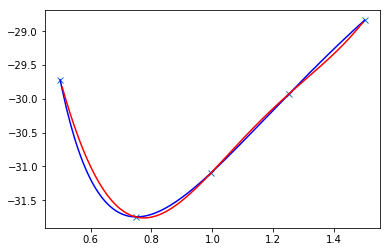

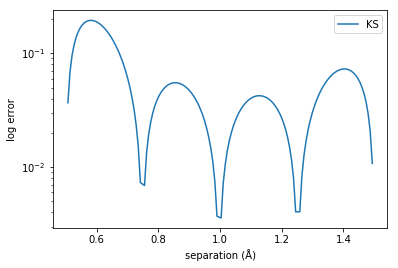

The KRR max error in kcal/mol is 4.522669778460852
The KRR MAE in kcal/mol is 1.3471636471512427
The cubic spline MAE in kcal/mol is 0.8513469259552956


In [3]:
# choose training set sizes
N = 150
M = 5
kcal_conv = 0.043

# choose hyperparameter grids
alphas = np.logspace(-20, -1, 6)
gammas = np.linspace(1, 10, 100)

# split into test and training
[train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N, seps, ens, fours)

if M < 10:
    cv = M-1
else:
    cv = 9

# fit the model and make plots
print('\n Current training set size: '+str(M))

[KS_kr, KS_pred, KS_errs, MAE, max_err] = fit_KS(train_set, train_ens, \
                                        test_set, test_ens, alphas, \
                                        gammas, cv, seps, ens)

# do spline test for comparison (what does KRR bring to the table?)
[spline_err, spline_errs] = spline_test(train_set, train_ens, test_set, test_ens)

# get full prediction
test = np.array(seps).reshape(150,1)
full_pred =KS_kr.predict(test)
KS_errs_full = full_pred - np.array(ens).reshape(150,1)

print('The KRR max error in kcal/mol is '+str(max_err / kcal_conv))
print('The KRR MAE in kcal/mol is '+str(MAE / kcal_conv))
print('The cubic spline MAE in kcal/mol is '+str(spline_err/kcal_conv))

In [6]:
# HK model

# choose train size
N = 150
M = 5
kcal_conv = 0.043

print('\n \n current training set size = '+str(M))

# split into test and training
[train_set, test_set, train_ens, test_ens, train_fours, test_fours] = get_train_test(M, N, seps, ens, fours)

# fit position to fourier models (i.e. create 15k+ KRR models)
alpha = 1e-10
gamma = 1
krs = pos_to_four(train_set, train_fours, M, alpha, gamma)

# fit fourier to energy model
[FE_kr, y_kr, errs, MAE, max_err] = four_to_en(train_fours, train_ens, M, N, seps, test_fours, test_ens)

print('\n Fourier to energy model:')
print(FE_kr.best_estimator_)
print('MAE='+str(MAE/kcal_conv))
print('max error='+str(max_err/kcal_conv))

# perform double mapping
seps_full = np.array(seps).reshape(150,1)
ens_full = np.array(ens).reshape(150,1)
[HK_errs, MAE, max_err, pred_ens] = doub_map_fast(seps_full, ens_full, krs, FE_kr, 150)

print('\n Double mapping:')
print('MAE='+str(MAE / kcal_conv))
print('max error='+str(max_err/kcal_conv))


 
 current training set size = 5

 Fourier to energy model:
KernelRidge(alpha=1e-20, coef0=1, degree=3, gamma=2.3644894126454072e-08,
      kernel='rbf', kernel_params=None)
MAE=0.7110628924335836
max error=3.0806373528550797

 Double mapping:
MAE=0.7578501766063473
max error=3.6099727694437402


In [1]:

# return to default and make the fontbigger
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 10}
plt.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4,5))

ax1.plot(seps, np.array(ens)/kcal_conv,'k')
ax1.plot(train_set, np.array(train_ens)/kcal_conv, 'kx')
ax1.plot(seps, full_pred/kcal_conv,':',label='KS')
ax1.plot(seps, pred_ens/kcal_conv,':',label='HK')

ax2.plot(seps, np.abs(KS_errs_full)/kcal_conv, label='KS')
ax2.plot(seps, np.abs(HK_errs)/kcal_conv, label='HK')
ax2.set_yscale('log')
ax2.set_ylim(1e-2,10)
ax1.set_ylim(-740,-660)

ax2.set_xlabel('separation (Å)')
ax2.set_ylabel('log error (kcal/mol)')
ax1.set_ylabel('energy (kcal/mol)')

fig.subplots_adjust(hspace=.3)
ax1.legend()

plt.show()
plt.show()

NameError: name 'plt' is not defined

# Figure 2: H2 GPs

In [121]:
seps = np.array(seps)
ens = np.array(ens)

In [130]:
# outsource to matlab

str_pref = '/Users/jonpvandermause/Documents/MATLAB/'

sp.io.savemat(str_pref+'H2_data.mat',dict(seps=seps, ens=ens, fours=fours))

In [117]:
# split into test and training
[train_set, test_set, train_ens, test_ens, train_fours, test_fours] = \
            get_train_test(M, N, seps, ens, fours)

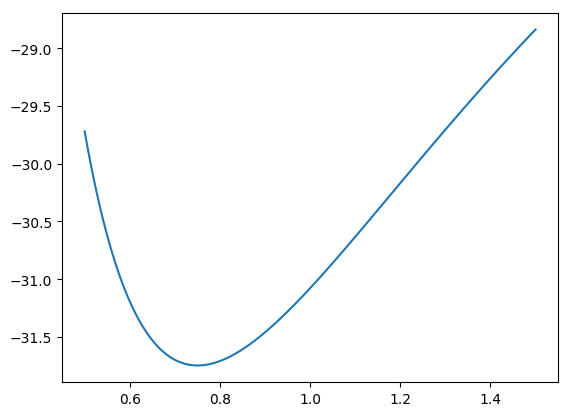

In [122]:
plt.plot(seps, ens)
plt.show()